In [1]:
%matplotlib inline
from __future__ import print_function
import os
from pyspark import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as sql
import pyspark.sql.types as types
#from pyspark.sql.functions import udf, length
import matplotlib.pyplot as plt
import numpy
import math
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import pyspark.ml.feature as feature

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [7]:
# Load Processed Parquet
sqlContext = SQLContext(sc)
phrases = sqlContext.read.parquet("../data/idigbio_phrases.parquet")\
    .sort(sql.col("count"), ascending=False)
total_records = phrases.count()
print(total_records)
phrases.printSchema()

36387
root
 |-- phrase: string (nullable = true)
 |-- count: long (nullable = true)



In [8]:
phrases.describe().show()
phrases.show(30, truncate=False)

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|            36387|
|   mean|8.472943633715339|
| stddev|294.8704551801091|
|    min|                1|
|    max|            52092|
+-------+-----------------+

+---------------------------------------+-----+
|phrase                                 |count|
+---------------------------------------+-----+
|intercept trap                         |52092|
|forest litter                          |12723|
|field notes                            |10554|
|field notebook                         |5607 |
|fogging fungus covered log             |4744 |
|tropical forest flight intercept trap  |3083 |
|for. litter berlese forest litter      |2874 |
|berlese forest litter                  |2724 |
|montane forest litter                  |2714 |
|flight intercept trap                  |2633 |
|rainforest litter                      |2445 |
|cloud forest flight intercept trap     |2434 |
|frank-t. krell            

In [10]:
# Median phrase count
import math
phrases\
    .select(sql.col("count"))\
    .limit(int(math.floor(total_records/2)))\
    .orderBy(sql.col("count"))\
    .show(3)

+-----+
|count|
+-----+
|    1|
|    1|
|    1|
+-----+
only showing top 3 rows



In [11]:
# ok, how many have more than 1?
phrases\
    .filter(sql.col("count") > 1)\
    .count()

10112

In [12]:
# distribution of phrase frequency
phrases_pdf = phrases.limit(10000).toPandas()

[]

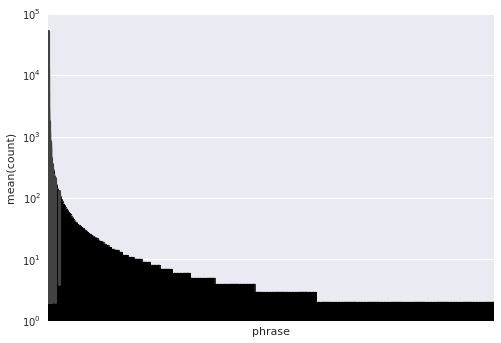

In [14]:
import seaborn as sns
ax = sns.barplot(x="phrase", y="count", data=phrases_pdf)
ax.set_yscale('log')
ax.get_xaxis().set_ticks([])

In [15]:
# write frequently used ones out
# Change col names to match nouns so we can use same OLS script
phrases\
    .filter(sql.col("count") > 1)\
    .select(sql.col("phrase").alias("noun"), sql.col("count"))\
    .write.format("json").save("../data/idigbio_phrases.json")

In [16]:
# Have done the lookups, now analize just the phrases we looked up
# Load Processed Parquet
ols = sqlContext.read.json("../data/idigbio_envo_terms.json")
ols = ols\
    .filter(sql.col("time") > "2016-04-19T00:00:00.00")

total_records = ols.count()
print(total_records)
#ols.printSchema()


9579


In [17]:
print(ols.filter(sql.col("term_id") != "").count())
print(ols.filter(sql.col("term_id") == "").count())

7917
1662


In [18]:
# Manually review a random sample of positive results and negative results
# Different random sample every time run
ols\
    .filter(sql.col("term_id") != "")\
    .sample(withReplacement=False, fraction=0.01)\
    .unionAll(
    ols\
        .filter(sql.col("term_id") == "")\
        .sample(withReplacement=False, fraction=0.02)
    )\
    .select(sql.col("noun"), sql.col("term_label"))\
    .show(1000, truncate=False)

+-----------------------------------------------------------------------+-------------------------------------------+
|noun                                                                   |term_label                                 |
+-----------------------------------------------------------------------+-------------------------------------------+
|dark blue-purple                                                       |blue cheese                                |
|herb. columbia college                                                 |herb and fern layer                        |
|surface. see field notes                                               |snow field                                 |
|brasil. regnell. musei bot. stockholm. plantae itineris regnelliani iii|flat glass                                 |
|herb. lafayette college                                                |herb and fern layer                        |
|laurelia novae-zelandiae leaf litter                   